# Testing the Samplers

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn

sys.path.append('../source/')
from MALA import MALA
from mMALA import mMALA
from metric_tensor import FisherInformationNormal
from RWHM import Metropolis_Hastings
from model import Model

In [2]:
X = pd.read_csv("../data/noisy_xor/data1/training/x.csv").to_numpy()
y = pd.read_csv("../data/noisy_xor/data1/training/y.csv").to_numpy().flatten()

X.shape, y.shape

((500, 2), (500,))

In [3]:
mlp = Model(sizes=[2, 2, 2], activations=[nn.ReLU(), nn.ReLU(), None])

In [4]:
N = 500
N_params = mlp.num_parameters()
N_steps = 100_000

epsilon_sq = np.square(0.75)

In [5]:
def log_target(theta):
    log_target_tensor = mlp.compute_log_target(X, y, theta)
    log_target_array = log_target_tensor.cpu().detach().numpy()
    return log_target_array

def grad_log_target(theta):
    log_target_tensor = mlp.compute_log_target(X, y, theta)
    grad_tensor = mlp.compute_grad_log_target(log_target_tensor)
    grad_array = grad_tensor.cpu().detach().numpy()
    return grad_array

In [6]:
mu = np.zeros(N_params)
sigma = np.ones(N_params)
theta_0 = np.random.multivariate_normal(mean=mu, cov=np.diag(sigma))
print(theta_0)

[ 0.10773531 -0.10754708 -0.89076796 -0.46869642 -0.38971174 -0.5516168
  0.37449704 -0.13288231 -0.25671981 -0.40478825 -1.56174337  1.62801143]


### RWHM

In [7]:
sigma_prop = 12_000

In [8]:
MH = Metropolis_Hastings(log_target,sigma_prop,theta_0)

sample_MH , acc_MH = MH.sample(N_steps)

print("Acceptance rate: ", acc_MH)

100%|██████████| 100000/100000 [00:30<00:00, 3282.68it/s]

Acceptance rate:  0.0


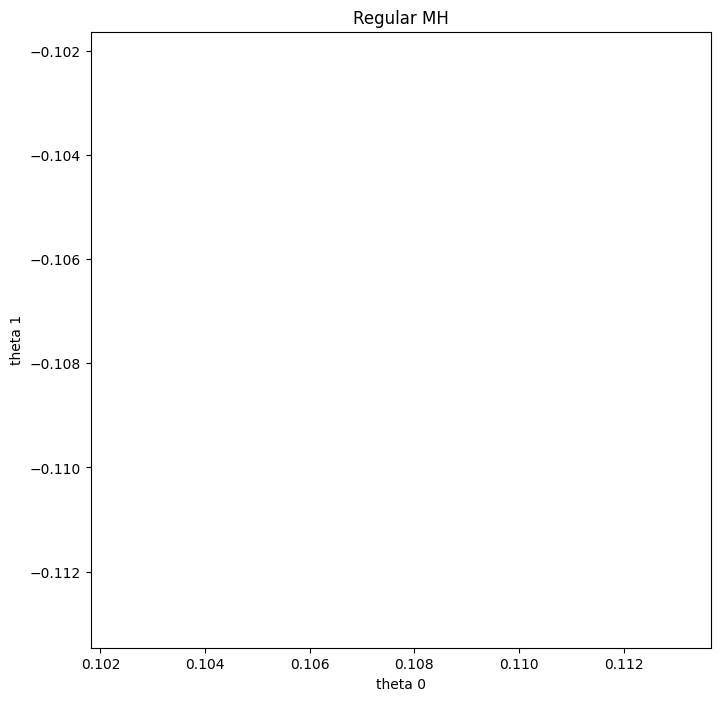

In [9]:
plt.figure(figsize=(8,8))
plt.plot(sample_MH[:,0], sample_MH[:,1], '-', color='black', alpha=1)
plt.xlabel('theta 0')
plt.ylabel('theta 1')
plt.title('Regular MH')
plt.show()

### MALA

In [10]:
regular_MALA = MALA(log_target, grad_log_target, epsilon_sq, theta_0)
sample, acceptance = regular_MALA.sample(N_steps)
print(acceptance)

Running MALA sampler...


100%|██████████| 100000/100000 [02:11<00:00, 761.17it/s]

0.0


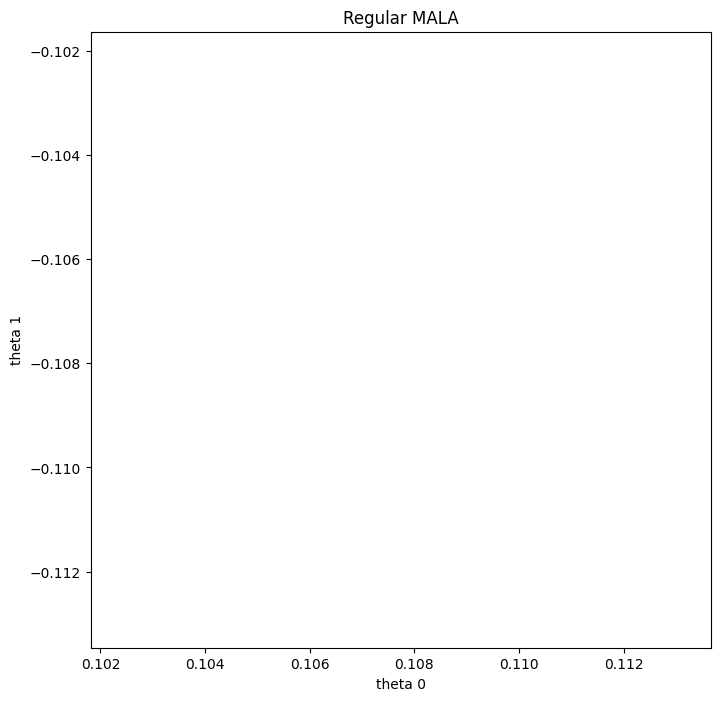

In [11]:
plt.figure(figsize=(8,8))
plt.plot(sample[:,0], sample[:,1], '-', color='black', alpha=1)
plt.xlabel('theta 0')
plt.ylabel('theta 1')
plt.title('Regular MALA')
plt.show()

### Riemann Manifold MALA

In [12]:
metric = FisherInformationNormal(N)
mMALA_ = mMALA(metric, log_target, grad_log_target, theta_0, epsilon_sq)
sample2, acceptance2 = mMALA_.sample(N_steps)
print(acceptance2)

Running mMALA sampler...




  0%|          | 0/100000 [00:00<?, ?it/s]


ValueError: shapes (2,2) and (12,) not aligned: 2 (dim 1) != 12 (dim 0)

Text(0.5, 1.0, 'mMALA')

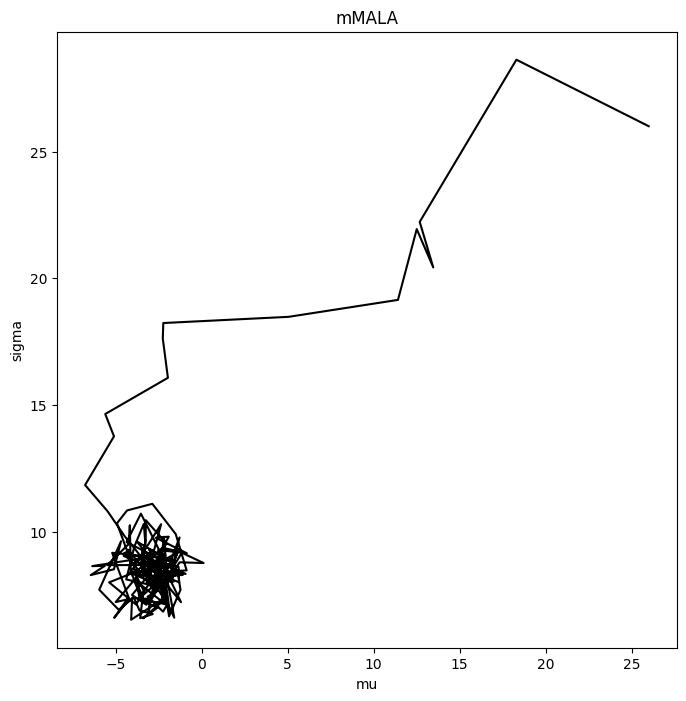

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(sample2[:,0], sample2[:,1], '-', color='black', alpha=1)
plt.xlabel('theta 0')
plt.ylabel('theta 1')
plt.title('mMALA')
plt.show()